In [1]:
import numpy as np
import abcpmc
#-- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Lets set up the usual toy example of fitting a line through data 

In [2]:
x = np.arange(20)
sigma_noise = 2.
theta_true = [2., 5.]

Below is our simulation/forward model. In this toy example we'll assume that we have the **exact** simulation used to generate the observations. This assumption is not always true in real life!

In [3]:
def FM(theta): 
    return theta[0] * x + theta[1]

We'll generate our observations by first generating a noiseless "true" observations then adding Gaussian noise. 

In [4]:
y_true = FM(theta_true)
y_obs = y_true + np.random.normal(loc=0, scale=sigma_noise, size=len(x))

(0.0, 20)

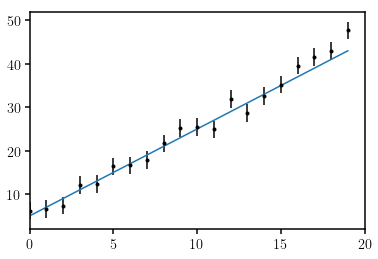

In [5]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(x, y_obs, sigma_noise, fmt='.k')
sub.plot(x, y_true, c='C0')
sub.set_xlim(0., 20)

*In principle*, we want to get our posterior by comparing the full observed data to the simulated data. This however is intractable so typically we define a "distance function" which compares the "distance" between the summary statistics of the observed data and the simulated data. 
$$\rho({\bf s}_{\rm data}, {\bf s}(\theta))$$

For simplicity we'll use L2 norm

In [6]:
def dist_fn(y_model, y_data): 
    # distrance function 
    return np.sum((y_model - y_data)**2/sigma_noise**2) # L2 norm

Define a prior space (simple tophat below)

In [7]:
prior = abcpmc.TophatPrior([0., 0.], [5., 10.])

Now lets implement the simplest and dumbest abc based on rejection sampling. That's the one where you
1. sample a random $\theta$ from your prior space
2. run it through your forward model $m(\theta)$
3. calculate the summary statistics $s(\theta)$
4. calculate $\rho(s_{\rm data}, s(\theta))$
5. check if the distance is within some preset threshold $\epsilon$ (has to be pretty small)
6. if it passes keep $\theta$ otherwise discard
7. repeat from step 1 until you get enough $\theta$s that pass

In [8]:
def prior_sampler(): 
    # function to randomly sample the prior space
    return np.random.uniform(size=2) * (prior.max - prior.min) + prior.min

In [9]:
# rejection sampling ABC
eps = 25.
particle_pool = []
for i in range(100000): 
    _theta_i = prior_sampler() 
    dist = dist_fn(FM(_theta_i), y_obs)
    
    if dist <= eps: 
        particle_pool.append(_theta_i)
    else: 
        continue

(0.0, 10.0)

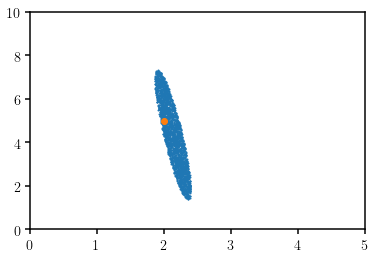

In [10]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(np.array(particle_pool)[:,0], np.array(particle_pool)[:,1], s=1) 
sub.scatter(theta_true[0], theta_true[1])
sub.set_xlim(0., 5.)
sub.set_ylim(0., 10.)

(0.0, 10.0)

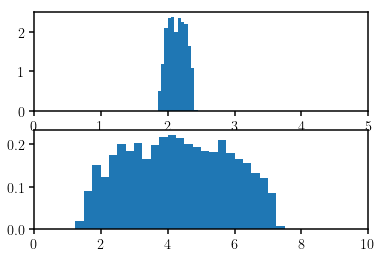

In [11]:
fig = plt.figure()
sub = fig.add_subplot(211)
sub.hist(np.array(particle_pool)[:,0], density=True, range=(0,5), bins=100)
sub.set_xlim(0.,5.)
sub = fig.add_subplot(212)
sub.hist(np.array(particle_pool)[:,1], density=True, range=(0,10.), bins=40)
sub.set_xlim(0.,10.)

In [12]:
eps0 = 1e5
Niter = 20

In [13]:
eps = abcpmc.ConstEps(Niter, eps0)

In [19]:
abc_sampler = abcpmc.Sampler(
    N=100, #N_particles
    Y=y_obs,             #data
    postfn=FM,            #simulator 
    dist=dist_fn #distance function  
    )  

abc_sampler.particle_proposal_cls = abcpmc.ParticleProposal

thetas = []
for pool in abc_sampler.sample(prior, eps):
    #while pool.ratio > 0.01:
    print('epislon = %f' % pool.eps)
    thetas.append(pool.thetas)
    #print(pool.ws)
    #print(pool.dists)

    eps.eps = np.median(pool.dists)
abc_sampler.close()

In [20]:
fig = plt.figure(figsize=(5, 5*len(thetas)))
for i in range(len(thetas)): 
    sub = fig.add_subplot(len(thetas),1,i+1)
    sub.scatter(thetas[i][:,0], thetas[i][:,1])
    sub.scatter(theta_true[0], theta_true[1], c='C1', s=5)
    sub.set_xlim([0., 5.])
    sub.set_ylim([0., 10.])

<Figure size 360x0 with 0 Axes>

In [16]:
theta_final = thetas[-1]

(0.0, 10.0)

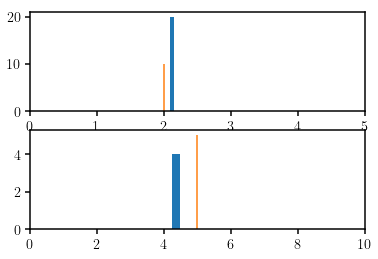

In [17]:
fig = plt.figure()
sub = fig.add_subplot(211)
sub.hist(theta_final[:,0], density=True, range=(0,5), bins=100)
sub.vlines(theta_true[0], 0., 10., color='C1')
sub.set_xlim(0.,5.)
sub = fig.add_subplot(212)
sub.hist(theta_final[:,1], density=True, range=(0,10.), bins=40)
sub.vlines(theta_true[1], 0., 5., color='C1')
sub.set_xlim(0.,10.)

Exercise: Compare ABC implementation to MCMC with Gaussian likelihood